Imports

In [2]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms as T
from torchvision import datasets
import matplotlib.pyplot as plt
import PIL

# Install Hugging Face Datasets

In [ ]:
#Install the Hugging Face Datasets library if you haven't already:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.1 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 2

Downloading the [Tiny ImageNet dataset](https://huggingface.co/datasets/zh-plus/tiny-imagenet)

In [ ]:
from datasets import load_dataset

# Load the train split of the Tiny ImageNet dataset
# Load the train, and validation of the Tiny ImageNet dataset
## we can split the training dataset to be having training and validation datasets

train_dataset = load_dataset('zh-plus/tiny-imagenet', split='train')
# split the training dataset into training and validation datasets
train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset,[90000,10000])

test_dataset = load_dataset('zh-plus/tiny-imagenet', split='valid')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/100000 [00:00<?, ? examples/s]

Generating valid split:   0%|          | 0/10000 [00:00<?, ? examples/s]

## Check For Gray scale Images in the dataset

In [ ]:
# Define a transform to convert images to tensors
transform = T.ToTensor()

# Function to check the size and number of channels of images in a dataset
def check_image_sizes_and_channels(dataset):
  counter_gray = 0
  for idx in range(len(dataset)): #idx in [0 ----89999]
        image = dataset[idx]['image']
        image_tensor = transform(image)
        channels, height, width = image_tensor.shape
        if channels != 3:
            counter_gray += 1
            #print(channels)
  print (f"Dataset contains {counter_gray} Gray scale images")

# Check image sizes and number of channels in the training dataset
check_image_sizes_and_channels(train_dataset)

Dataset contains 1646 Gray scale images


Filter the train,test, valid datasets from gray-scale images

In [ ]:
# Define a transform to convert images to tensors
transform = T.ToTensor()

# Function to filter out grayscale images
def filter_rgb_images(dataset):
    filtered_dataset = []
    for idx in range(len(dataset)):
        image = dataset[idx]['image']
        image_tensor = transform(image)
        channels, height, width = image_tensor.shape
        if channels == 3:
            filtered_dataset.append(dataset[idx])

    return filtered_dataset

# Filter the training, testing and validation datasets
filtered_train_dataset = filter_rgb_images(train_dataset)
filtered_valid_dataset = filter_rgb_images(valid_dataset)
filtered_test_dataset = filter_rgb_images(test_dataset)

# Display the number of images in the filtered datasets
print(f"Number of images in the filtered training dataset: {len(filtered_train_dataset)}")
print(f"Number of images in the filtered validation dataset: {len(filtered_valid_dataset)}")
print(f"Number of images in the filtered testing dataset: {len(filtered_test_dataset)}")

Number of images in the filtered training dataset: 88378
Number of images in the filtered validation dataset: 9801
Number of images in the filtered testing dataset: 9832


In [ ]:
transform(filtered_train_dataset[4]['image']).shape

torch.Size([3, 64, 64])

In [ ]:
#Find shape of each image
print(transform(filtered_train_dataset[0]['image']).shape)


torch.Size([3, 64, 64])


In [ ]:
#Show some images and labels (200 classes For tiny ImageNet)
#filtered_train_dataset[5]['image']
print(filtered_train_dataset[5]['label'])

149


# Integrate the dataset with PyTorch for use in a neural network



1.   Create Custom DataClass For that dataset
2.   Create DataLoaders using the DataClasses




---






In [ ]:
#Create Custom Dataset object Since Tiny Image net doesn't have a Pytorch Dataset Object already created
#Unlike Fashion Mnist and Hand written Digits

class TinyImageNetDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image = self.dataset[idx]['image']
        label = self.dataset[idx]['label']

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
# Define transformations
transform = T.Compose([
    T.Resize(68),
    T.CenterCrop(64), #The size of images in mydataset is 64 x 64
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

#DataClass For each dataset which will be a parameter for the dataloader
train_dataClass = TinyImageNetDataset(filtered_train_dataset, transform = transform)
test_dataClass = TinyImageNetDataset(filtered_test_dataset, transform   = transform)
valid_dataClass = TinyImageNetDataset(filtered_valid_dataset, transform = transform)



#Create DataLoader For Each Dataset
TrainLoader = DataLoader(train_dataClass, batch_size=32, shuffle=True)
TestLoader  = DataLoader(test_dataClass, batch_size=32, shuffle=True)
ValidLoader = DataLoader(valid_dataClass, batch_size=32, shuffle=True)


Check that the DataLoaders *Wrapped* dataset correctly


In [ ]:
#Check the dimensions when fetching data From the Data Loader
dataiter = iter(TrainLoader) #queue containing the batches
images, labels = next(dataiter) #fetches the next batch in the queue
print(type(images))
print(images.shape)
print(labels.shape)
print(labels)

<class 'torch.Tensor'>
torch.Size([32, 3, 64, 64])
torch.Size([32])
tensor([130, 179,  23, 106,  63, 180,  11,  27, 184,  29,  32, 160, 129,   0,
          3, 107,  63,  28,  94,  71,   6, 132,  27,  97,  51,  98, 164,  32,
          0,  61, 199, 176])


**Visualizing Dataset**

In [ ]:
import matplotlib.pyplot as plt

def train_imshow(data_loader):
    dataiter = iter(data_loader)

    images_RGB, labels = next(dataiter) #dataiter.next() in older versions
    #print(images_RGB[0].shape)
    fig, axes = plt.subplots(figsize=(20, 8), ncols=5)
    for i in range(5):
        ax = axes[i]
        ax.imshow(images_RGB[i].permute(1, 2, 0))  #Permute Converts image size from 3x32x32 to 32x32x3
        #print(images_RGB[i].permute(1, 2, 0).shape)
        ax.title.set_text(' '.join('%5s' % data_loader.dataset.dataset[i]['label'])) #name the image of class value
    plt.show()

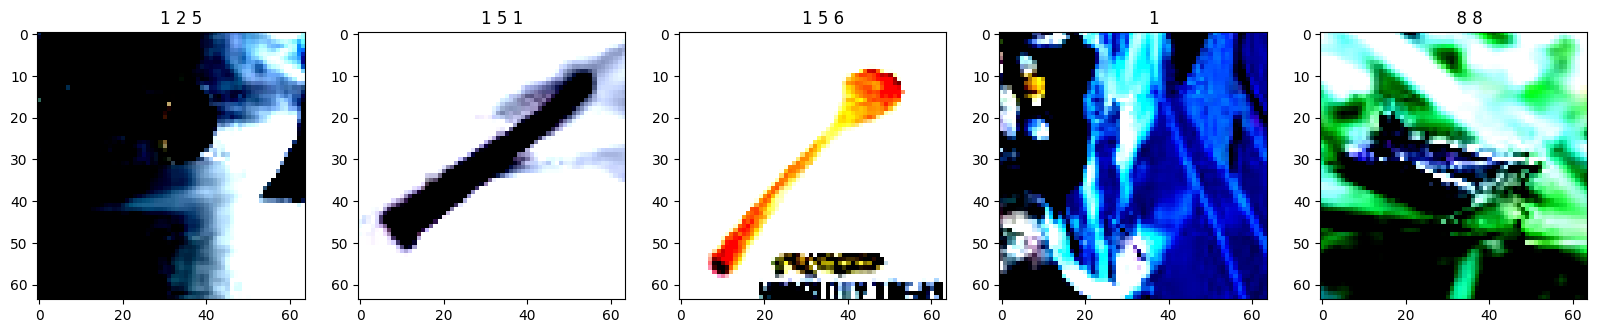

In [ ]:
train_imshow(TrainLoader)

# Data Augmentation

Random Affine (**Scaling**)

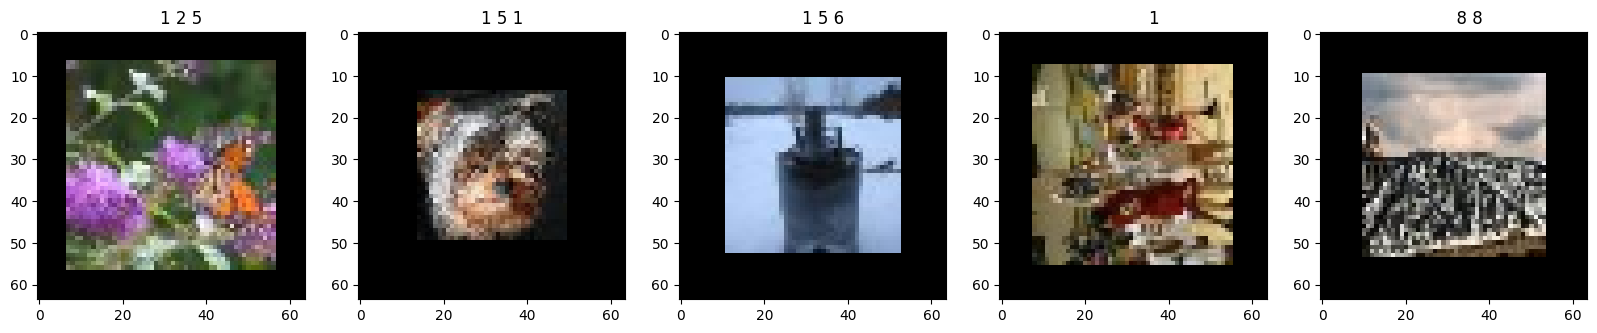

In [ ]:
# Scaling #(0.9,0.9) #(1.1,1.1)
train_transform = T.Compose([
    T.RandomAffine(scale=(0.5,1.5),degrees=0, interpolation = T.InterpolationMode.BILINEAR),
    T.ToTensor(),          ])

#DataClass For each dataset
train_dataClass = TinyImageNetDataset(filtered_train_dataset, transform=train_transform)

#Create DataLoader For Each Dataset
TrainLoader = DataLoader(train_dataClass, batch_size=32, shuffle=True)
train_imshow(TrainLoader)

#ToDo: Try Scaling  #(1.5,1.5) with both Bilinear and Nearest Interpolation and comment


Random Affine (**Translation**)


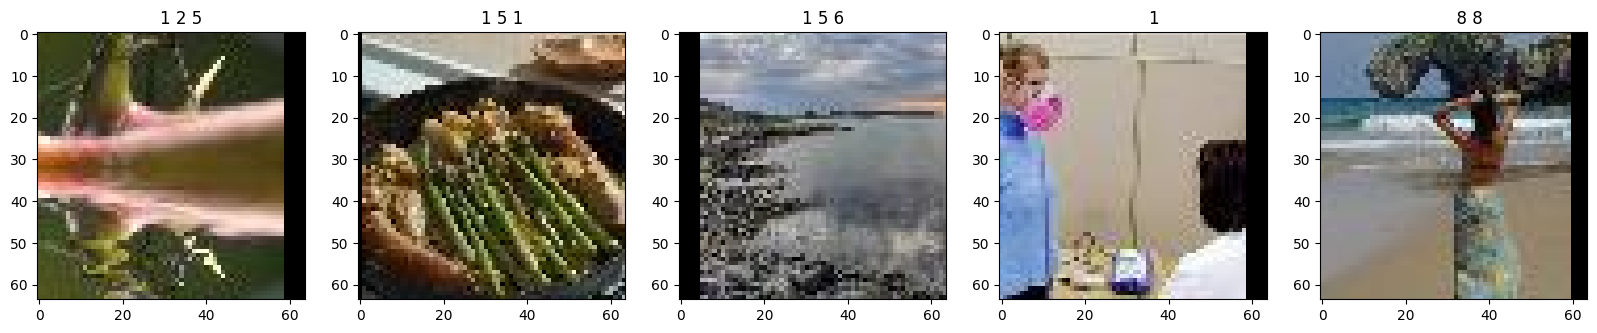

In [ ]:
# Translation
import torchvision.transforms as T
#translate =(0.1,0) x translation up to 10% of image width. No translation in height
train_transform = T.Compose([T.RandomAffine(translate =(0.1,0), degrees=0,
                                               interpolation = T.InterpolationMode.BILINEAR ),
                                T.ToTensor(),
                               ])
#DataClass For each dataset
train_dataClass = TinyImageNetDataset(filtered_train_dataset, transform=train_transform)
#Create DataLoader For Each Dataset
TrainLoader = DataLoader(train_dataClass, batch_size=32, shuffle=True)
train_imshow(TrainLoader)

Random Affine (**All**)

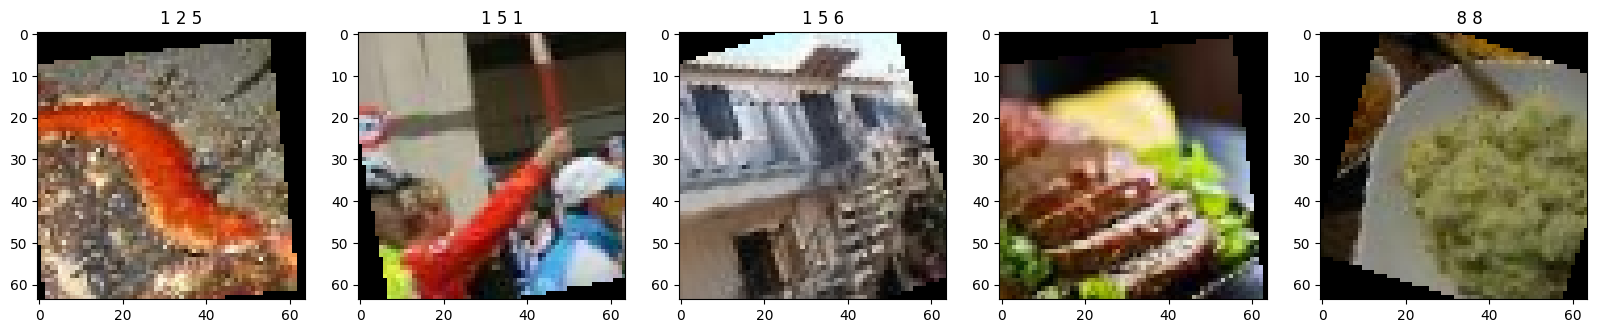

In [ ]:
#Random affine applies each one of the used transforms but with random parameters
# All
import torchvision.transforms as T
train_transform = T.Compose([T.RandomAffine(translate =(0.1,0.1), degrees = 20, scale=(0.9,1.1),
                                               interpolation = T.InterpolationMode.BILINEAR ),
                               T.ToTensor(),
                               ])
#degrees=20 is randomly taken a value from 0 - 20

#DataClass For each dataset
train_dataClass = TinyImageNetDataset(filtered_train_dataset, transform=train_transform)
#Create DataLoader For Each Dataset
TrainLoader = DataLoader(train_dataClass, batch_size=32, shuffle=True)
train_imshow(TrainLoader)

Color Jitter

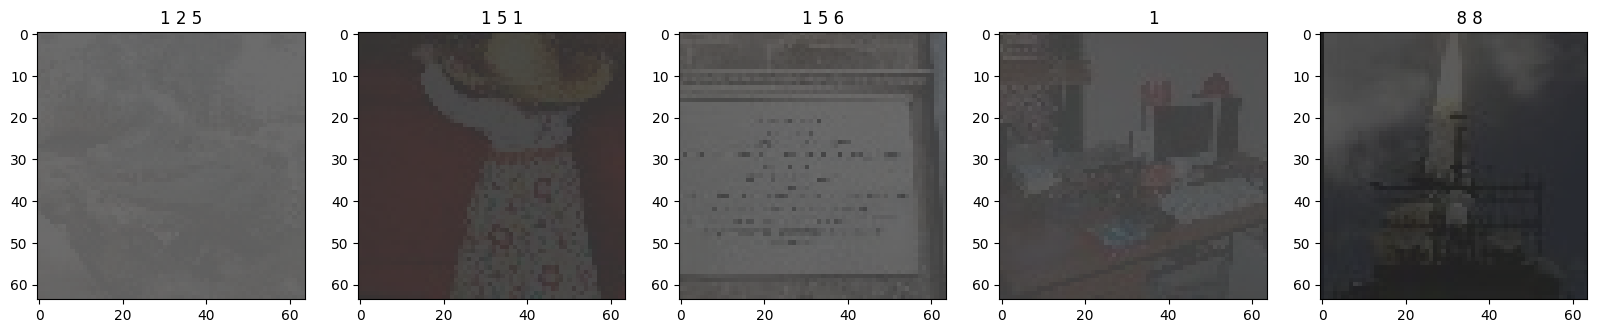

In [ ]:
# ColorJitter Randomly change the brightness, contrast, saturation and hue of an image
import torchvision.transforms as T
train_transform = T.Compose([T.ColorJitter(brightness=(0.5,1),contrast=(0,.5)),
                                T.ToTensor(),
                               ])
#DataClass For each dataset
train_dataClass = TinyImageNetDataset(filtered_train_dataset, transform=train_transform)
#Create DataLoader For Each Dataset
TrainLoader = DataLoader(train_dataClass, batch_size=32, shuffle=True)
train_imshow(TrainLoader)

Random Flip with a given probability

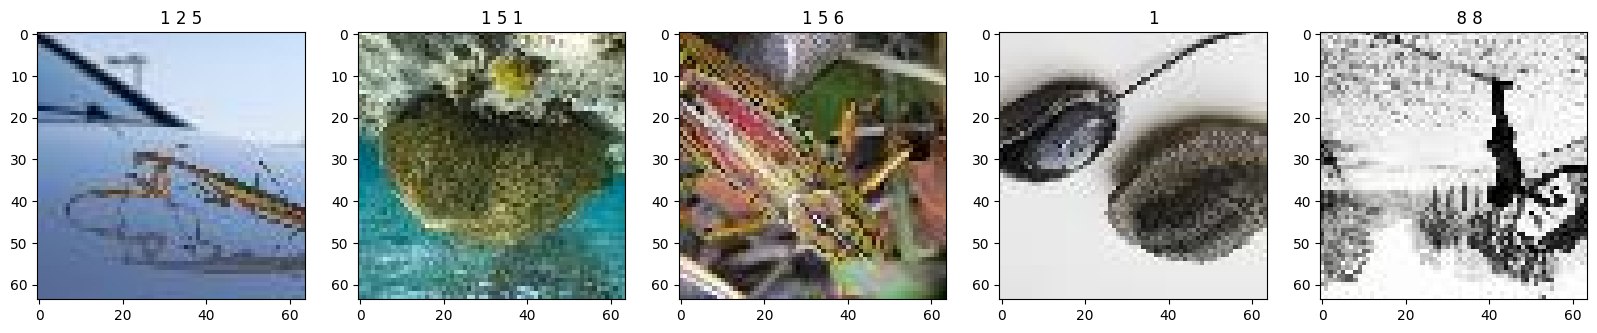

In [ ]:
#Random Horizontal flib
import torchvision.transforms as T
train_transform = T.Compose([T.RandomVerticalFlip(p=0.5),
                                T.ToTensor(),
                               ])
#RandomVerticalFlip
#DataClass For each dataset
train_dataClass = TinyImageNetDataset(filtered_train_dataset, transform=train_transform)
#Create DataLoader For Each Dataset
TrainLoader = DataLoader(train_dataClass, batch_size=32, shuffle=True)
train_imshow(TrainLoader)

Adding all together

In [ ]:
#Data Augmentation is done for the training datset and not for validation or testing, Correct?

import torchvision.transforms as T
train_transform = T.Compose([T.RandomAffine(translate =(0.1,0.1), degrees=0,  interpolation = T.InterpolationMode.BILINEAR ),
                                T.ColorJitter(brightness=(0.5,1),contrast=(0.5,1)),
                                T.RandomHorizontalFlip(p=0.2),
                                T.Resize(68),
                                T.CenterCrop(64),
                                T.ToTensor(),
                                T.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
                               ])

valid_transform = T.Compose ([T.Resize(68),
    T.CenterCrop(64),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
#ToDo: Initialize the three data classes and Three dataloaders


#Create DataLoader For Each Dataset
TrainLoader = DataLoader(train_dataClass, batch_size=32, shuffle=True)
TestLoader  = DataLoader(test_dataClass, batch_size=32, shuffle=True)
ValidLoader = DataLoader(valid_dataClass, batch_size=32, shuffle=True)



# Batch Normalization in CNN Architecture

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class MyCNN(nn.Module):
    def __init__(self):
        # We optimize dropout rate in a convolutional neural network.
        super(MyCNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels = 3, out_channels=16, kernel_size=3, stride=1, padding= 1)
        self.bn1 = nn.BatchNorm2d(16)

        self.conv2 = nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=1,padding=1)
        #ToDo: Create a seconed Batch normalization layer called self.bn2
        self.bn2 = nn.BatchNorm2d(32)

        self.drop=nn.Dropout2d(p=0.2)

        ## ToDo: Create a MaxPool Layer of size (2,2) name it self.pool
        self.pool = nn.MaxPool2d(kernel_size = 2)

        self.fc1 = nn.Linear(8192, 4096) #2^12 = 4096
        self.bn3 = nn.BatchNorm1d(4096)   ###### Notice BatchNorm1d
        self.fc2 = nn.Linear(4096, 1024) #1024 = 2^10
        self.bn4 = nn.BatchNorm1d(1024)   ###### Notice BatchNorm1d
        self.fc3 = nn.Linear(1024, 200)   # 200 classes


    def forward(self, x):
        #ToDo: Replace question marks with your solution

        x = self.pool(self.bn1(F.relu(self.conv1(x))))  #  3 x 64 x 64 ->  16 x 64 x 64 ->  16 x 32 x 32
        x = ?? # 16 x 32 x 32   -->  32 x 32 x 32 ->  32 x 16 x 16
        x = self.drop(x)

        x = x.view(x.size(0),-1)             #32 x 16 x 16 -->8192

        x = self.bn3(F.relu(self.fc1(x)))    #8192 ->4096
        x = ??          #4096 ->1024
        x = self.fc3(x)                              #1024--> 200 #No Softmax or Logsoftmax activation layer added

        return x

# Do not change the name of yo'ur model or later cells may fail!
model = MyCNN()
model.to(device)

MyCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop): Dropout2d(p=0.2, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=8192, out_features=4096, bias=True)
  (bn3): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=4096, out_features=1024, bias=True)
  (bn4): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=1024, out_features=200, bias=True)
)

### Specify Optimizer and Losse

In [ ]:
#Use adam Optimizer (LR=0.002) and Cross Entropy as a loss function
#ToDo: Replace question marks with your solution
optimizer = ??
criterion =  ??

In [ ]:
# Saving the model with the highest Validation accuracy
# Tracing Losses and accuracies and saving them in a dictionary called "history"

history={'train_loss':[],'valid_loss':[],'train_acc':[],'valid_acc':[]}
num_epochs=50
Validation_loss=float("inf")

for epoch in range(num_epochs):
    train_loss,train_correct=0.0,0

    model.train()
    for images, labels in TrainLoader:

        images,labels = images.to(device),labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output,labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        scores, predictions = torch.max(output.data, 1)
        train_correct += (predictions == labels).sum().item()     #Correctly classified Images

    valid_loss, val_correct = 0.0, 0

    model.eval()
    for images, labels in ValidLoader:

        images,labels = images.to(device),labels.to(device)
        output = model(images)
        loss=criterion(output,labels)
        valid_loss+=loss.item()*images.size(0)
        scores, predictions = torch.max(output.data,1)
        val_correct += (predictions == labels).sum().item()

    train_loss = train_loss / len(TrainLoader.sampler)
    train_acc = train_correct / len(TrainLoader.sampler)*100
    valid_loss = valid_loss / len(ValidLoader.sampler)
    valid_acc = val_correct / len(ValidLoader.sampler) * 100

    print("Epoch:{}/{} \t AVERAGE TL:{:.4f} AVERAGE VL:{:.4f} \t AVERAGE TA:{:.2f} %  AVERAGE VA:{:.2f} %".format(epoch + 1, num_epochs,
                                                                                         train_loss,
                                                                                         valid_loss,
                                                                                         train_acc,
                                                                                        valid_acc))
    #Check for best validation loss and use corresponding model
    if valid_loss< Validation_loss:
        Validation_loss=valid_loss
        best_model_state = model.state_dict()

    history['train_loss'].append(train_loss)
    history['valid_loss'].append(valid_loss)
    history['train_acc'].append(train_acc)
    history['valid_acc'].append(valid_acc)

torch.save(best_model_state, 'Best_model.pth')

Epoch:1/50 	 AVERAGE TL:3.7717 AVERAGE VL:7.9415 	 AVERAGE TA:17.60 %  AVERAGE VA:18.20 %
Epoch:2/50 	 AVERAGE TL:3.6399 AVERAGE VL:5.0558 	 AVERAGE TA:19.50 %  AVERAGE VA:22.92 %
Epoch:3/50 	 AVERAGE TL:3.5576 AVERAGE VL:3.7089 	 AVERAGE TA:21.01 %  AVERAGE VA:21.85 %
Epoch:4/50 	 AVERAGE TL:3.5492 AVERAGE VL:15.1183 	 AVERAGE TA:21.18 %  AVERAGE VA:23.49 %
Epoch:5/50 	 AVERAGE TL:3.5096 AVERAGE VL:4.2652 	 AVERAGE TA:21.65 %  AVERAGE VA:18.82 %
Epoch:6/50 	 AVERAGE TL:3.4118 AVERAGE VL:3.7211 	 AVERAGE TA:23.26 %  AVERAGE VA:24.54 %
Epoch:7/50 	 AVERAGE TL:3.4049 AVERAGE VL:3.5377 	 AVERAGE TA:23.39 %  AVERAGE VA:23.91 %
Epoch:8/50 	 AVERAGE TL:3.3315 AVERAGE VL:3.4902 	 AVERAGE TA:24.60 %  AVERAGE VA:25.51 %
Epoch:9/50 	 AVERAGE TL:3.2884 AVERAGE VL:3.3949 	 AVERAGE TA:25.44 %  AVERAGE VA:26.04 %
Epoch:10/50 	 AVERAGE TL:3.2802 AVERAGE VL:3.3080 	 AVERAGE TA:25.75 %  AVERAGE VA:26.83 %
Epoch:11/50 	 AVERAGE TL:3.2001 AVERAGE VL:3.3717 	 AVERAGE TA:27.03 %  AVERAGE VA:26.75 %
Epoch:1

### Complexity Graph

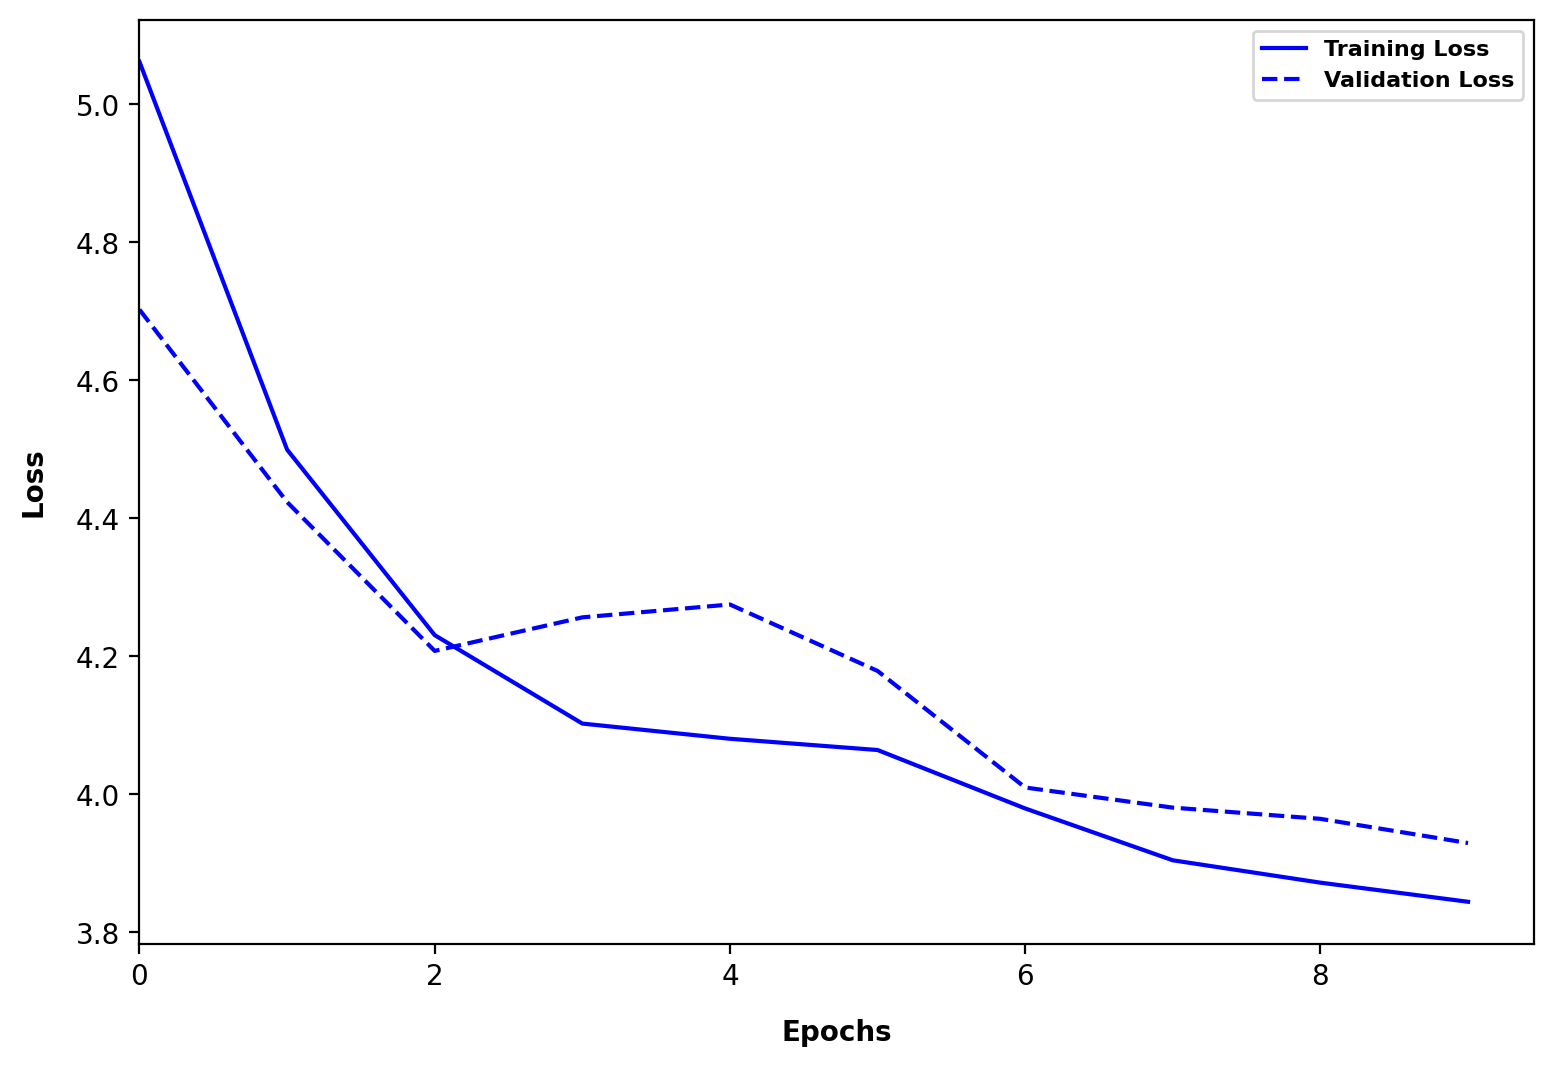

In [ ]:

epochs=10
fig=plt.figure(figsize=(9,6),dpi=200)
x=[epoch for epoch in range(epochs)]
plt.plot(x,history['train_loss'],'b',label='Training Loss')
plt.plot(x,history['valid_loss'],'b',linestyle='dashed',label='Validation Loss')

plt.xlabel("Epochs",fontweight='bold',labelpad=10)
plt.ylabel("Loss",fontweight='bold',labelpad=10)
plt.xlim(xmin = 0)

plt.legend(prop={'size': 8,'weight':'bold'},loc="best")

plt.savefig(r'Losses.png',bbox_inches="tight")
plt.show()

### Testing your model

In [ ]:
#ToDo: Upload the best model saved
????

correct = 0
total = 0
test_loss = 0
with torch.no_grad():

    for images, labels in TestLoader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs,labels)
        test_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_loss = test_loss / len(TestLoader.sampler)

print('Accuracy of the network on the test images: {:.2f} %%'.format(100 * correct / total))
print('Loss of the network on the test images: {:.4f}'.format(test_loss))

Accuracy of the network on the test images: 17.50 %%
Loss of the network on the test images: 3.9596
